# Credit risk modeling in Python - part 7

In [1]:
# Commands to get to same point for data in previous notebooks
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from patsy import dmatrices
import statsmodels.api as sm

data = pd.read_csv("creditrisk_pydata_nas.csv", index_col = 0)
data = data[data.age < 100]
data = data[data.children < 30]
data = data[data.address < (data.age + 2)]
data[(data.employer > (data.age - 14))]
data = data[(data.employer < (data.age - 14)) | data.employer.isnull()]
data.amount.fillna(data.amount.median(), inplace = True)

bins = [0, 10, 20 ,30, 40, 50]
bins_emp1 = pd.cut(data['employer'], bins)

bins = [0, 2, 5 ,10, 15, 50, 70]
bins_emp2 = pd.cut(data['employer'], bins)
bins_emp2.fillna("(50, 70]", inplace = True)
bins_emp2 = bins_emp2.cat.rename_categories(["(0, 2]","(2, 5]","(5, 10]","(10, 15]","(15, 50]", "unknown"])
bins_emp2 = bins_emp2.cat.as_unordered()

data['employer']= bins_emp2

data['payfreq'] = data['payfreq'].astype('category')
data['marstat'] = data['marstat'].astype('category')
data['home'] = data['home'].astype('category')

data['payfreq'] = data['payfreq'].cat.rename_categories(["quarter","bimon","monthly","biweek"])
data['marstat'] = data['marstat'].cat.rename_categories(["single","married","divorced","widowed"])
data['home'] = data['home'].cat.rename_categories(["yes", "no"])

data.dropna(inplace = True)
data_ML = data[((data["default"] == 1) | (data["month"] == 24))]

# create dataframes with an intercept column and dummy variables
y, X = dmatrices('default ~ age + amount + address + C(employer) + \
                  children + C(payfreq) + C(marstat) + C(home)',
                  data_ML, return_type = "dataframe")
print(X.columns)

# fix column names of X
X = X.rename(columns = {'C(employer)[T.(2, 5]]':'emp_(2, 5]',
                        'C(employer)[T.(5, 10]]':'emp_(5, 10]',
                        'C(employer)[T.(10, 15]]':'emp_(10, 15]',
                        'C(employer)[T.(15, 50]]':'emp_(15, 50]',
                        'C(employer)[T.unknown]':'emp_unknown',
                        'C(payfreq)[T.bimon]':'freq_bimon',
                        'C(payfreq)[T.monthly]':'freq_monthly',
                        'C(payfreq)[T.biweek]':'freq_biweek',
                        'C(marstat)[T.married]': 'ms_married',
                        'C(marstat)[T.divorced]': 'ms_divorced',
                        'C(marstat)[T.widowed]':'ms_widowed', 
                        'C(home)[T.no]': 'home_no'})
# default (y) to array, for scikit-learn to properly understand it as a response
y = np.ravel(y)


# log reg through statsmodels.api
logit_model = sm.Logit(y, X)
result = logit_model.fit()

# log regression model on all the data using scikit learn (C = inverse regularization strength)
logreg = LogisticRegression(fit_intercept = False, C = 1e12)
model_log = logreg.fit(X, y)
model_log

# scikit-learn train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=0)
model_log_eval = LogisticRegression()
model_log_eval.fit(X_train, y_train)


predict_1= np.array([1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 50, 4000, 24, 1]).reshape(1, -1)

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

Index(['Intercept', 'C(employer)[T.(2, 5]]', 'C(employer)[T.(5, 10]]',
       'C(employer)[T.(10, 15]]', 'C(employer)[T.(15, 50]]',
       'C(employer)[T.unknown]', 'C(payfreq)[T.bimon]',
       'C(payfreq)[T.monthly]', 'C(payfreq)[T.biweek]',
       'C(marstat)[T.married]', 'C(marstat)[T.divorced]',
       'C(marstat)[T.widowed]', 'C(home)[T.no]', 'age', 'amount', 'address',
       'children'],
      dtype='object')
Optimization terminated successfully.
         Current function value: 0.369322
         Iterations 7


### 3.3 Decision trees

#### 3.3.1 Building a tree

In [2]:
# Decision Tree Classifier
from sklearn import metrics
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from os import system
from sklearn.tree import export_graphviz
import graphviz

Building a tree is an **iterative process**, tuning some parameters while **constantly evaluating the tree**.

This is why here, we immediately start building a tree using the **same training and test sets** as used in the logistic regression model.

**First tree: "default tree" (i.e., no maximum depth, no maximum leafs,...)**

In [3]:
dt_full = DecisionTreeClassifier()
dt_full.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

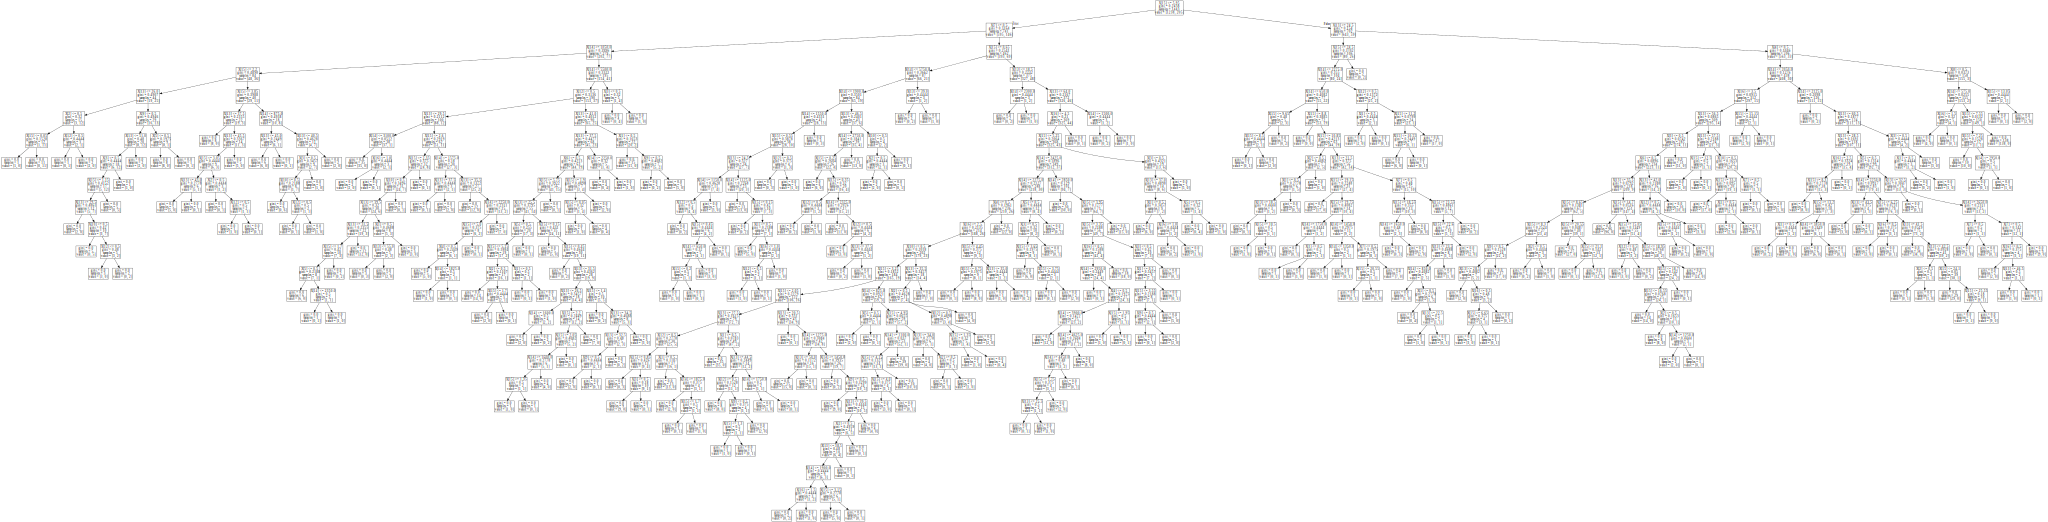

In [4]:
export_graphviz(dt_full, out_file="mytree.dot")
with open("mytree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

As shown, this creates a massive tree. Hard to tell what is going on. Let's see how we can specify some arguments.

- **criterion**: either `gini` for gini impurity, or `entropy` for information gain.
- **max_depth**: the maximum depth of a tree.
- **min_samples_split**: minimum amount of samples required to split an internal node. 
- **min_samples_leaf**: The minimum number of samples required to be at a leaf node.
- **class_weight**: Weights associated with classes.

In what follows we are going to look at **three smaller trees**.

**1) Specify a maximum depth of 3**

In [5]:
dt_part1 = DecisionTreeClassifier(criterion = "gini", max_depth = 3)
dt_part1.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

** 2) Specify a minimum samples split and a minimum samples leaf **

In [6]:
dt_part2 = DecisionTreeClassifier(criterion = "gini", min_samples_split = 50,
                                min_samples_leaf = 10, max_depth = 6)
dt_part2.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=10,
            min_samples_split=50, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

** 3) Balance the class weights **

In [7]:
dt_part3 = DecisionTreeClassifier(criterion = "gini", class_weight= "balanced", 
                                  max_depth = 5, min_samples_leaf = 12)
dt_part3.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=12,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

Now, let's have a look at what these trees look like

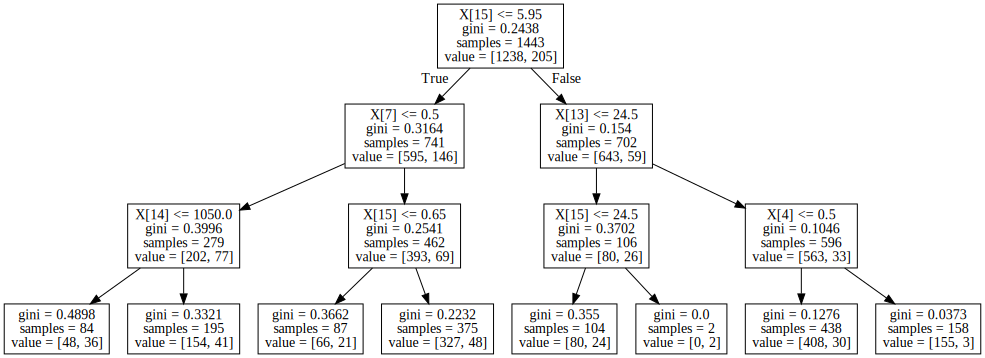

In [8]:
export_graphviz(dt_part1, out_file="mytree.dot")
with open("mytree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

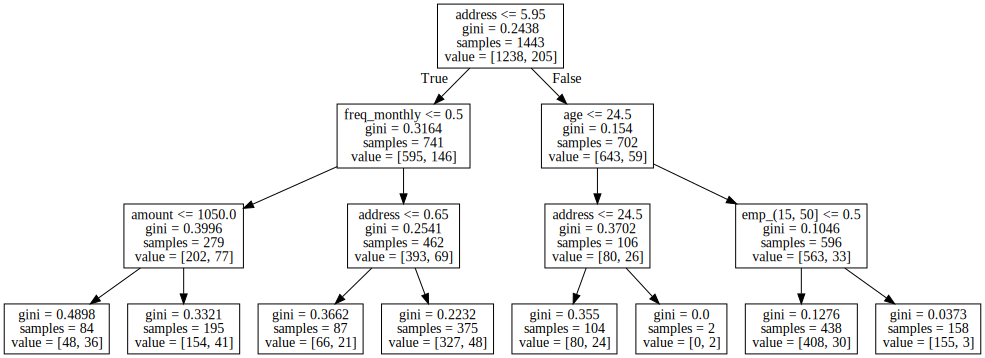

In [9]:
export_graphviz(dt_part1, out_file="mytree.dot", feature_names = X_train.columns)
with open("mytree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

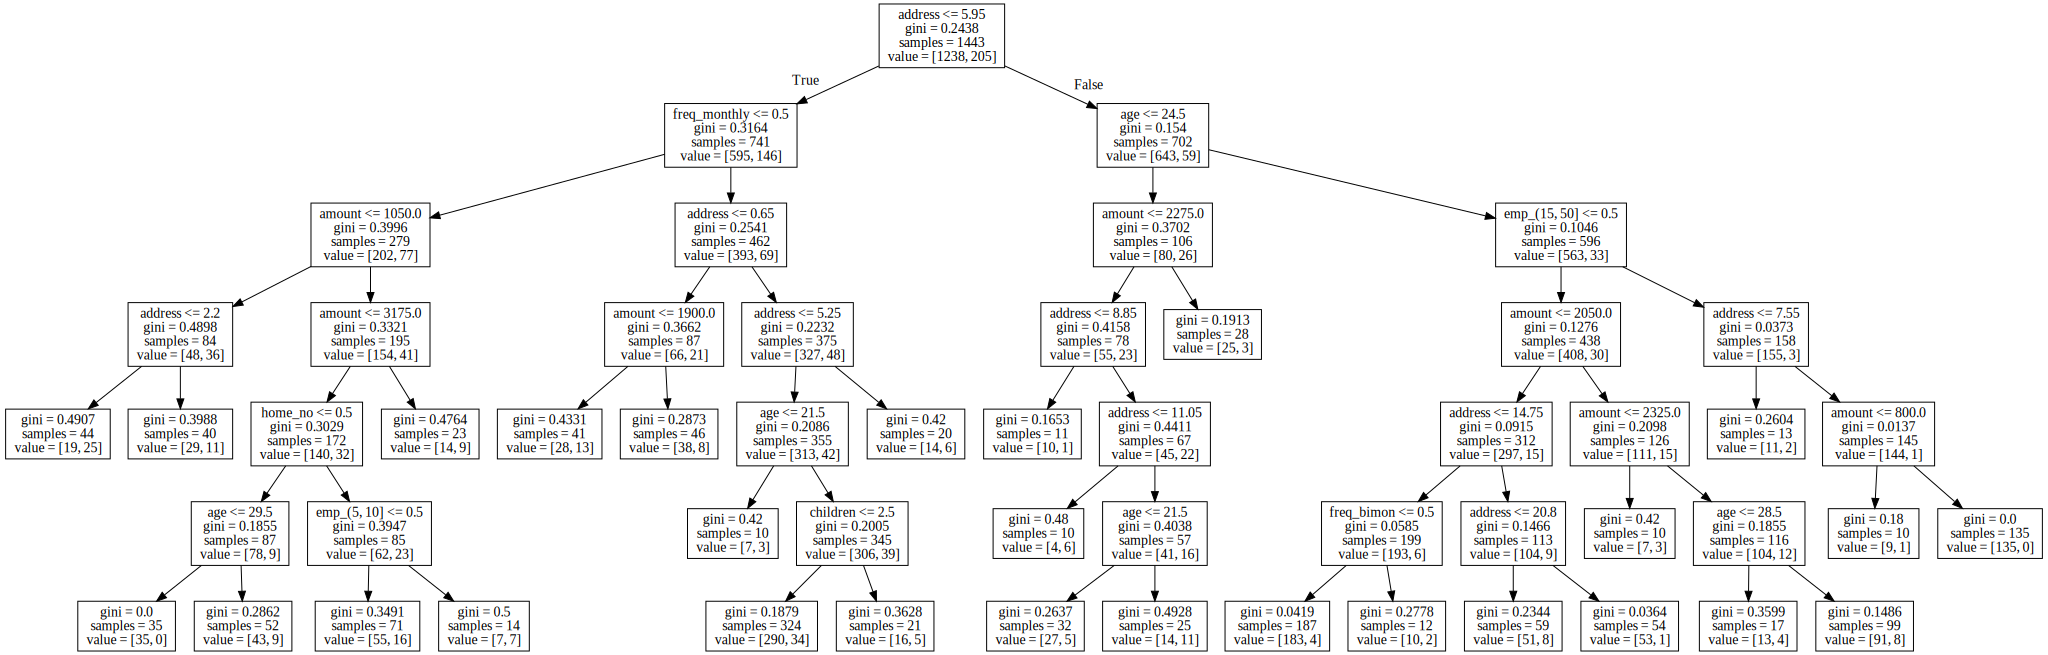

In [10]:
export_graphviz(dt_part2, out_file="mytree.dot", feature_names=X_train.columns)
with open("mytree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

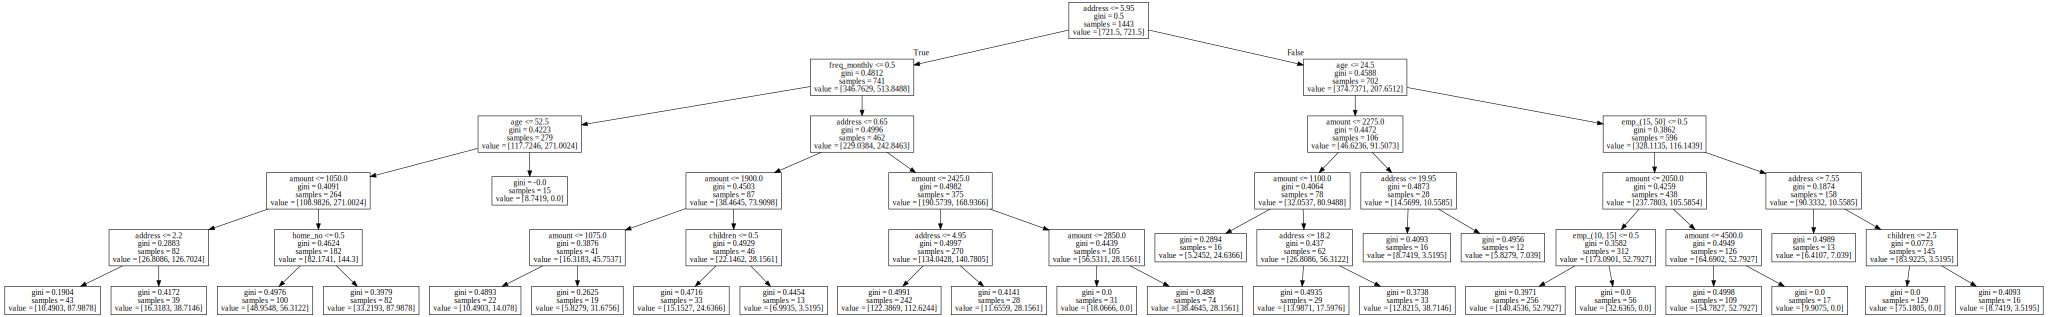

In [11]:
export_graphviz(dt_part3, out_file="mytree.dot", feature_names=X_train.columns)
with open("mytree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

In [ ]:
# Try to change some arguments yourself here!

dt_part_try = DecisionTreeClassifier(criterion = "gini", max_depth = ___,
                                     min_samples_leaf = ___,
                                     min_samples_leaf = ___, 
                                     max_depth = ___)
dt_part_try.fit(X_train, y_train)

export_graphviz(dt_part_try, out_file="mytree.dot", feature_names=X_train.columns)
with open("mytree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)


#### 3.3.2 Model evaluation  

##### a. Accuracy and confusion matrices

In [13]:
pred_full = dt_full.predict(X_test)
print(metrics.confusion_matrix(y_test, pred_full))
print(metrics.classification_report(y_test, pred_full))

[[543  69]
 [ 80  20]]
             precision    recall  f1-score   support

        0.0       0.87      0.89      0.88       612
        1.0       0.22      0.20      0.21       100

avg / total       0.78      0.79      0.79       712



In [14]:
pred_part1 = dt_part1.predict(X_test)
print(metrics.confusion_matrix(y_test, pred_part1))
print(metrics.classification_report(y_test, pred_part1))

[[612   0]
 [ 99   1]]
             precision    recall  f1-score   support

        0.0       0.86      1.00      0.93       612
        1.0       1.00      0.01      0.02       100

avg / total       0.88      0.86      0.80       712



In [15]:
pred_part2 = dt_part2.predict(X_test)
print(metrics.confusion_matrix(y_test, pred_part2))
print(metrics.classification_report(y_test, pred_part2))

[[595  17]
 [ 96   4]]
             precision    recall  f1-score   support

        0.0       0.86      0.97      0.91       612
        1.0       0.19      0.04      0.07       100

avg / total       0.77      0.84      0.79       712



In [16]:
pred_part3 = dt_part3.predict(X_test)
print(metrics.confusion_matrix(y_test, pred_part3))
print(metrics.classification_report(y_test, pred_part3))

[[447 165]
 [ 45  55]]
             precision    recall  f1-score   support

        0.0       0.91      0.73      0.81       612
        1.0       0.25      0.55      0.34       100

avg / total       0.82      0.71      0.74       712



- Can also compute probabilities for trees, and chose cut-offs.
- Yet, need for ROC becomes apparent: we can look at several cut-offs for all these models, but 
   - cut-off 0.3 might be better for tree A
   - cut-off 0.4 might be better for tree B
   - Also: using ROC, we can compare our logistic regression-result with any tree!

##### b. The AUC and ROC-curve

In [17]:
prob_full = dt_full.predict_proba(X_test)
prob_dt1 = dt_part1.predict_proba(X_test)
prob_dt2 = dt_part2.predict_proba(X_test)
prob_dt3 = dt_part3.predict_proba(X_test)

In [18]:
print(roc_auc_score(y_test, prob_full[:,1]))
print(roc_auc_score(y_test, prob_dt1[:,1]))
print(roc_auc_score(y_test, prob_dt2[:,1]))
print(roc_auc_score(y_test, prob_dt3[:,1]))

0.54362745098
0.645816993464
0.612222222222
0.650849673203


Let's have a look at the ROC curve for the best tree, and compare it to the logistic regression result

In [19]:
fpr, tpr, _ = roc_curve(y_test, prob_dt3[:,1])

In [20]:
# bring back in the old log results:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr_log, tpr_log, thresholds_log = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])

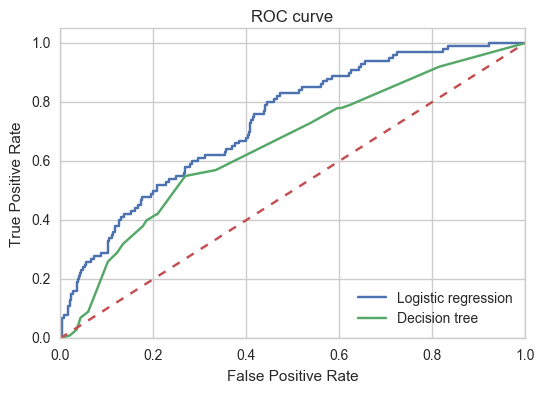

In [21]:
plt.figure()
plt.plot(fpr_log, tpr_log, label='Logistic regression')
plt.plot(fpr, tpr, label='Decision tree')
plt.plot([0, 1], [0, 1],'r--')
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

#### 3.3.3 Using the third decision tree to predict the probability of default

In [22]:
predict_instance= np.array([1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
                            0, 1, 1, 50, 4000, 24, 1]).reshape(1, -1)

In [23]:
dt_part3.predict_proba(predict_instance)

array([[ 0.50924947,  0.49075053]])

### 3.4 Conclusion

- Based on metrics, logistic regression model is more successful.
- Yet, many more ways to try and tweak decision trees, so might not be necessary to give up yet.
- Some more possibilities to make models better: 
   - use different link functions in logistic regression
   - do feature selection
   - look at other evaluation metrics
   - ...

## 4. Time-dependent estimates for loan default: survival analysis

### 4.1 What is survival analysis?

![](surv_func.png)

### 4.2 Why survival analysis?

- We had to throw a lot of data out, even though we definitely know that they were repaying up until a certain point.
- It is in many cases also important to know up until what time people were repaying.
- Time-dependent probabilities!

### 4.2 Plotting the Kaplan Meier function

In [24]:
import lifelines
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
from matplotlib import pyplot as plt

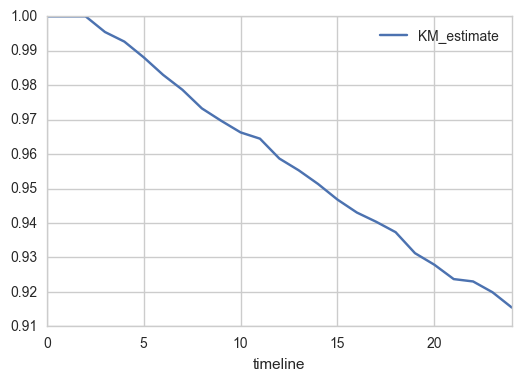

In [25]:
kmf.fit(data['month'], data['default'])
kmf.survival_function_.plot()
plt.show()

### 4.3 Building a survival analysis model

- Use full data now (we can keep the censored cases!)
- Make dummies for categorical variables, but no intercept
- Most famous model: semi-parametric "Cox PH model"
  - Non-parametric "baseline hazard"
  - Parametric function

In [26]:
# create dataframes with an intercept column and dummy variables for employer, payfreq, marstat and home
y, X = dmatrices('default ~ month + age + amount + address + C(employer) + \
                  children + C(payfreq) + C(marstat) + C(home)',
                  data, return_type="dataframe")
# fix column names of X
X = X.rename(columns = {'C(employer)[T.(2, 5]]':'emp_(2, 5]',
                        'C(employer)[T.(5, 10]]':'emp_(5, 10]',
                        'C(employer)[T.(10, 15]]':'emp_(10, 15]',
                        'C(employer)[T.(15, 50]]':'emp_(15, 50]',
                        'C(employer)[T.unknown]':'emp_unknown',
                        'C(payfreq)[T.bimon]':'freq_bimon',
                        'C(payfreq)[T.monthly]':'freq_monthly',
                        'C(payfreq)[T.biweek]':'freq_biweek',
                        'C(marstat)[T.married]': 'ms_married',
                        'C(marstat)[T.divorced]': 'ms_divorced',
                        'C(marstat)[T.widowed]':'ms_widowed', 
                        'C(home)[T.no]': 'home_no'})

In [27]:
data_surv = pd.concat([y, X.drop("Intercept", axis=1)], axis=1)

In [28]:
from lifelines import CoxPHFitter
cph = CoxPHFitter()
cph.fit(data_surv, duration_col='month', event_col='default')
cph.print_summary()  # access the results using cph.summary

n=3959, number of events=305

                coef  exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95     
emp_(2, 5]   -0.3807     0.6834    0.1507 -2.5263 0.0115     -0.6762     -0.0853    *
emp_(5, 10]  -0.6160     0.5401    0.1650 -3.7337 0.0002     -0.9395     -0.2926  ***
emp_(10, 15] -1.0038     0.3665    0.2723 -3.6867 0.0002     -1.5375     -0.4700  ***
emp_(15, 50] -1.4739     0.2290    0.3168 -4.6531 0.0000     -2.0949     -0.8529  ***
emp_unknown  -0.4287     0.6514    0.2043 -2.0981 0.0359     -0.8293     -0.0281    *
freq_bimon   -0.3719     0.6894    0.3443 -1.0800 0.2801     -1.0469      0.3032     
freq_monthly -0.5601     0.5712    0.1210 -4.6302 0.0000     -0.7972     -0.3230  ***
freq_biweek   0.2250     1.2524    0.4569  0.4926 0.6223     -0.6706      1.1206     
ms_married   -0.0882     0.9156    0.1624 -0.5428 0.5873     -0.4066      0.2303     
ms_divorced   0.4285     1.5349    0.2286  1.8747 0.0608     -0.0196      0.8766    .
ms_widowed    0.1954    

In [29]:
# These are the 2 arrays used in predictions before, but without intercept value!
predict_instance= np.array([0, 0, 0, 0, 0, 0, 1, 0, 0,
                            0, 1, 1, 50, 4000, 24, 1]).reshape(1, -1)
predict_2 = np.array([0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
                     1, 1, 38, 9000, 2, 1]).reshape(1, -1)

pred=np.concatenate((predict_instance, predict_2), axis=0)

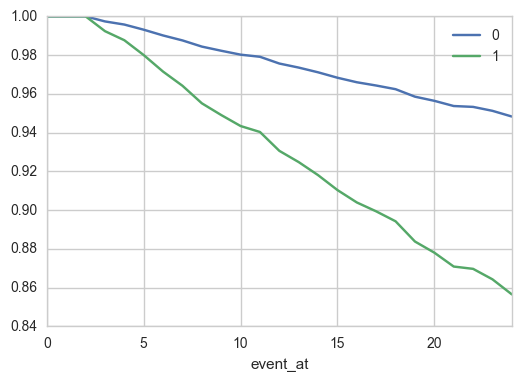

In [30]:
cph.predict_survival_function(pred).plot()
plt.show()

### 4.4 Conclusions

Advantages of survival analysis:
    - Nice, intuitive curve
    - Can incorporate censoring: more complete view
    - New perspective on EL = PD * EAD * LGD
Disadvantage:
    - More complex: baseline hazard
    - Evalation? ROC? Classification matrix? R vs Python




**THANK YOU!!**

Sources:
- http://nbviewer.jupyter.org/gist/justmarkham/6d5c061ca5aee67c4316471f8c2ae976
- https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8
- http://scikit-learn.org/stable/_downloads/scikit-learn-docs.pdf
- http://lifelines.readthedocs.io/en/latest/Survival%20analysis%20with%20lifelines.html